In [7]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_FOLDER='data_templates/'
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(DATA_FOLDER+'aac_intakes_outcomes.csv', usecols=columns)

In [9]:
def train_test_split(df,p=0.8):
    shuffled_df=df.iloc[np.random.permutation(len(df))]
    
    Train=shuffled_df.iloc[:int(p*len(df))]
    Test=shuffled_df.iloc[int(p*len(df)):]
    
    return Train,Test

In [11]:
original_data['outcome_type']=(original_data['outcome_type']=='Adoption').astype(int)
Train,Test=train_test_split(original_data)

features=original_data.columns[np.logical_not(original_data.columns=='outcome_type')]
label='outcome_type'

X_train,y_train=Train[features],Train[label]
X_test,y_test=Test[features],Test[label]

# Dummy categorical features

In [12]:
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)

# Normalization

In [13]:
for column in X_train.columns:
    mean=X_train[column].mean()
    std=X_train[column].std()
    X_train[column]=(X_train[column]-mean)/std
    X_test[column]=(X_test[column]-mean)/std

# SMF Linear

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df = pd.read_csv(DATA_FOLDER + 'heart_failure_clinical_records_dataset.csv')
mod = smf.ols(formula='time ~ C(high_blood_pressure) * C(DEATH_EVENT,  Treatment(reference=0)) + C(diabetes)',
              data=df)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     31.92
Date:                Sun, 10 Jan 2021   Prob (F-statistic):           4.32e-22
Time:                        21:00:54   Log-Likelihood:                -1671.0
No. Observations:                 299   AIC:                             3352.
Df Residuals:                     294   BIC:                             3371.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# SMF logistic

In [60]:
for column in ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']:
    df[column] = (df[column] - df[column].mean())/df[column].std()
    
mod = smf.logit(formula='DEATH_EVENT ~  age + creatinine_phosphokinase + ejection_fraction + \
                        platelets + serum_creatinine + serum_sodium + \
                        C(diabetes) + C(high_blood_pressure) +\
                        C(sex) + C(anaemia) + C(smoking) + C(high_blood_pressure)', data=df)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.492108
         Iterations 6


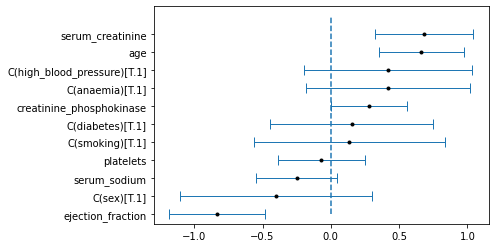

In [63]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
#res.conf_int()

#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

# Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train,y_train)

# Confusion matrix, accuracy, precision,....

In [19]:
threshold=0.5
def predict(X,threshold):
    return (clf.predict_proba(X)[:,1]>threshold).astype(int)

def confusion_matrix(y_pred,y_true):
    
    TP=((y_pred==1) & (y_true==1)).sum()
    FN=((y_pred==0) & (y_true==1)).sum()
    
    TN=((y_pred==0) & (y_true==0)).sum()
    FP=((y_pred==1) & (y_true==0)).sum()
    
    confusion=np.array([[TP,FP],[FN,TN]])
    confusion=pd.DataFrame(confusion)
    confusion.index=pd.MultiIndex.from_tuples([('Predicted','True'),('Predicted','False')])
    confusion.columns=pd.MultiIndex.from_tuples([('Actual','True'),('Actual','False')])
    return confusion

def characteristics(confusion,print_values=False):
    [[TP,FP],[FN,TN]]=confusion.to_numpy()

    if print_values:
        print('Accuracy {:.2f}'.format((TP+TN)/confusion.sum().sum()))
        print('Precision positive {:.2f}, Recall positive {:.2f}, F1 {:.2f}'.format(
            TP/(TP+FP),TP/(TP+FN),TP/(TP+0.5*(FP+FN))))
        print('Precision negative {:.2f}, Recall negative {:.2f}, F1 {:.2f}'.format(
            TN/(TN+FN),TN/(TN+FP),TN/(TN+0.5*(FP+FN))))
        
    return [(TP+TN)/confusion.sum().sum(),(TP/(TP+FP),TP/(TP+FN),TP/(TP+0.5*(FP+FN))),(TN/(TN+FN),TN/(TN+FP),TN/(TN+0.5*(FP+FN)))]

In [20]:
y_pred=predict(X_test,threshold)

confusion=confusion_matrix(y_pred,y_test)
confusion

Actual      
                  True False
Predicted True    5605  1619
          False   1168  7543

In [21]:
_=characteristics(confusion,print_values=True)

Accuracy 0.83
Precision positive 0.78, Recall positive 0.83, F1 0.80
Precision negative 0.87, Recall negative 0.82, F1 0.84


<ipython-input-19-cddbc5d60f50>:29: RuntimeWarning: invalid value encountered in long_scalars
  return [(TP+TN)/confusion.sum().sum(),(TP/(TP+FP),TP/(TP+FN),TP/(TP+0.5*(FP+FN))),(TN/(TN+FN),TN/(TN+FP),TN/(TN+0.5*(FP+FN)))]
<ipython-input-19-cddbc5d60f50>:29: RuntimeWarning: invalid value encountered in long_scalars
  return [(TP+TN)/confusion.sum().sum(),(TP/(TP+FP),TP/(TP+FN),TP/(TP+0.5*(FP+FN))),(TN/(TN+FN),TN/(TN+FP),TN/(TN+0.5*(FP+FN)))]


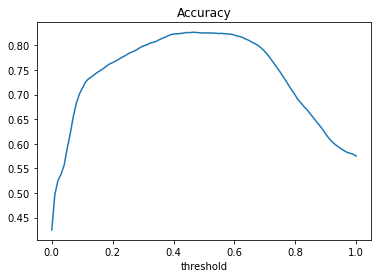

In [22]:
thresholds=np.linspace(0,1,100)
accuracy=np.zeros(100)
Positive_ch=np.zeros((3,100))
Negative_ch=np.zeros((3,100))

for i,threshold in enumerate(thresholds):
    y_pred=predict(X_test,threshold)
    confusion=confusion_matrix(y_pred,y_test)
    [accuracy[i],Positive_ch[:,i],Negative_ch[:,i]]=characteristics(confusion)
    
plt.plot(thresholds,accuracy)
plt.title('Accuracy')
plt.xlabel('threshold')
plt.show()

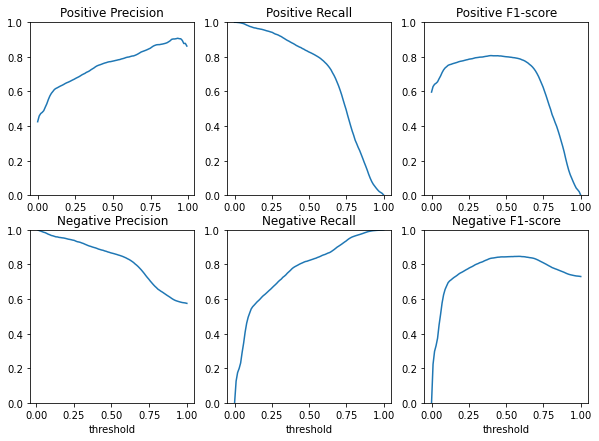

In [23]:
fig,ax=plt.subplots(2,3,figsize=(10,7))
charact_names=['Precision','Recall','F1-score']
charact_types=['Positive','Negative']
charact_values=[Positive_ch,Negative_ch]

for i in range(2):
    for j in range(3):
        ax[i,j].plot(thresholds,charact_values[i][j])
        ax[i,j].set_title(charact_types[i]+' '+charact_names[j])
        ax[i,j].set_ylim((0,1))
        if i==1:
            ax[i,j].set_xlabel('threshold')

# Logistic regression coeffitients

<BarContainer object of 32 artists>

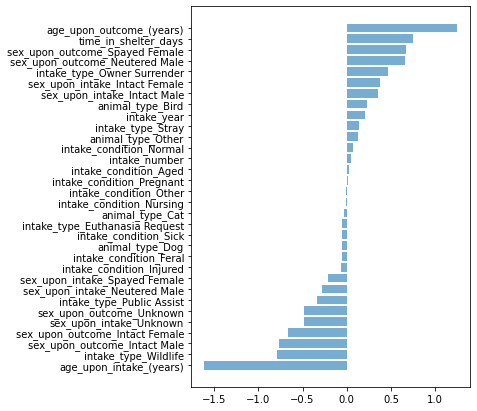

In [48]:
coefs=pd.DataFrame(data=clf.coef_[0],columns=['value'])
coefs['name']=X_train.columns
coefs=coefs.sort_values('value')
plt.subplots(figsize=(5,7))
plt.barh(coefs.name, coefs.value, alpha=0.6)

# Random forest

# Search for two hyperparameters

In [49]:
from sklearn.ensemble import RandomForestClassifier
n_estimators=[10,25,50,100]
max_depth=[2,4,10]

accuracies=np.zeros((4,3))

for i,nt in tqdm(enumerate(n_estimators)):
    for j,depth in enumerate(max_depth):
        clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=nt)
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        accuracy = (y_pred==y_test).sum()/len(y_pred)
        accuracies[i,j]=accuracy

4it [00:20,  5.00s/it]


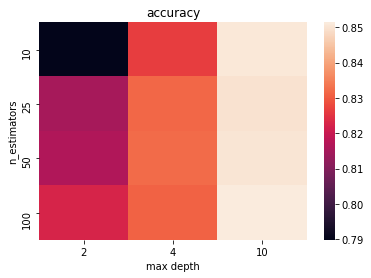

In [50]:
ax=sns.heatmap(accuracies,yticklabels=n_estimators,xticklabels=max_depth)
ax.set_title('accuracy')
plt.xlabel('max depth')
plt.ylabel('n_estimators')
plt.show()

# Search for one hyperparameter

In [56]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

number_trees = [n for n in range(10, 15)]
precision_scores = []
recalls_scores = []


for nt in number_trees:
    clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=nt)
    clf.fit(X_train, y_train)
    precision = cross_val_score(clf, X_train, y_train, cv=10, scoring="precision")
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, X_train, y_train, cv=10, scoring="recall")
    recalls_scores.append(recall.mean())

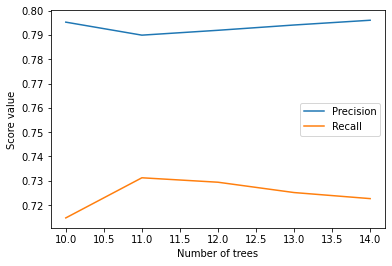

In [57]:
fig, ax = plt.subplots(1, figsize=(6,4))

ax.plot(number_trees, precision_scores, label="Precision")
ax.plot(number_trees, recalls_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()

# Random forest features

Text(0.5, 0, 'Feature importance')

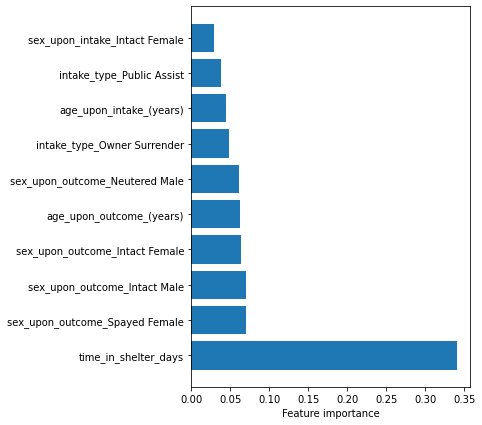

In [58]:
clf = RandomForestClassifier(max_depth=max_depth[-1], random_state=0, n_estimators=n_estimators[-1]).fit(X_train,y_train)
feature_importance=pd.Series(index=X_train.columns,data=clf.feature_importances_)
top_features=feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index).iloc[:10]
plt.subplots(figsize=(5,7))
plt.barh(top_features.index, top_features.values)
plt.xlabel('Feature importance')